## Reference Annotation
## https://github.com/sayakpaul/Transfer-Learning-with-CIFAR10

In [1]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
# from keras.engine import Model
from keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [3]:
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [6]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [7]:
# X_train = np.array([sp.misc.imresize(x, 
#                                      (48, 48)) for x in X_train])
# X_val = np.array([sp.misc.imresize(x, 
#                                    (48, 48)) for x in X_val])
# X_test = np.array([sp.misc.imresize(x, 
#                                     (48, 48)) for x in X_test])

# imresize is deprecated! imresize is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
# Use scikit-image instead
from skimage.transform import resize
X_train = np.array([resize(x, 
                                     (48, 48)) for x in X_train])
X_val = np.array([resize(x, 
                                   (48, 48)) for x in X_val])
X_test = np.array([resize(x, 
                                    (48, 48)) for x in X_test])

In [8]:
base_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

2021-10-05 17:16:17.934630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 17:16:17.939431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 17:16:17.939876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 17:16:17.940709: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [10]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [11]:
for layer in base_model.layers:
     layer.trainable = False

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [14]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [15]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [16]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [17]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

2021-10-05 17:16:19.298656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-10-05 17:16:19.950453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


1328/1328 [==============================] - 7s 4ms/step - loss: 0.3115 - accuracy: 0.2828 - val_loss: 0.2425 - val_accuracy: 0.4646
Epoch 2/100
1328/1328 [==============================] - 5s 4ms/step - loss: 0.2493 - accuracy: 0.4311 - val_loss: 0.2196 - val_accuracy: 0.5140
Epoch 3/100
1328/1328 [==============================] - 5s 4ms/step - loss: 0.2312 - accuracy: 0.4811 - val_loss: 0.2078 - val_accuracy: 0.5439
Epoch 4/100
1328/1328 [==============================] - 5s 4ms/step - loss: 0.2201 - accuracy: 0.5100 - val_loss: 0.1998 - val_accuracy: 0.5622
Epoch 5/100
1328/1328 [==============================] - 6s 4ms/step - loss: 0.2127 - accuracy: 0.5264 - val_loss: 0.1944 - val_accuracy: 0.5725
Epoch 6/100
1328/1328 [==============================] - 5s 4ms/step - loss: 0.2064 - accuracy: 0.5456 - val_loss: 0.1897 - val_accuracy: 0.5847
Epoch 7/100
1328/1328 [==============================] - 5s 4ms/step - loss: 0.2014 - accuracy: 0.5558 - val_loss: 0.1860 - val_accuracy: 0.59

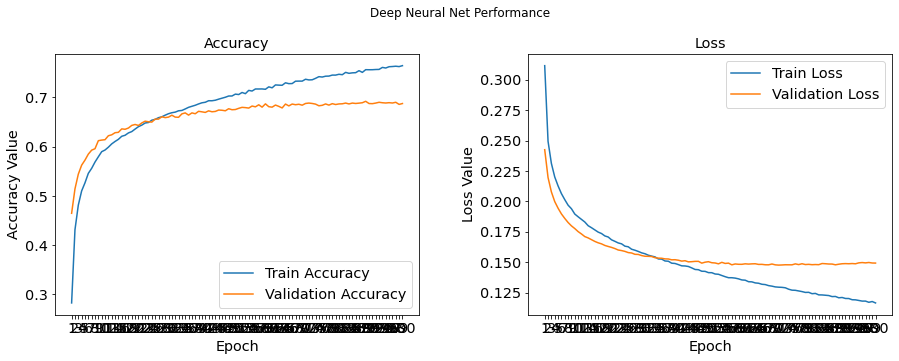

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
predictions = model.predict(X_test/255.)

In [20]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [21]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.6892
Precision: 0.6904
Recall: 0.6892
F1 Score: 0.6892


In [22]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
3
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
8
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
8
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
3
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1


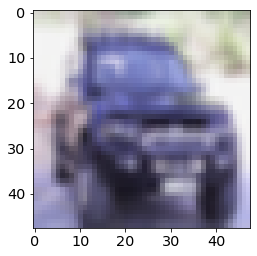

In [23]:
for i in range(10):
    plt.imshow(X_test[i])
    print(Y_test[i])
    print(predictions[i])